# Learning and Decision Making

## Laboratory 4: MNIST

In the end of the lab, you should save the notebook as `padi-lab4-groupXX.ipynb`, where the `XX` corresponds to your group number and should be submitted to the e-mail <adi.tecnico@gmail.com>. 

Make sure that the subject is of the form `[<group n.>] LAB <lab n.>`.

### 1. The MNIST dataset

The National Institute of Standards and Technology (NIST) published in 1995 a corpus for handprinted document and character recognition. The corpus originally contained 810,000 character images from 3,600 different writers. The MNIST ("Modified NIST") dataset was created from the original NIST dataset and contains a total of 70,000 normalized images ($28\times28$ pixels) containing handwritten digits. All images are grayscale and anti-aliased. 

---

In this lab, we work with a simplified version of the MNIST dataset, in order to have the algorithms run in a manageable amount of time. In such modified dataset, digit images have been pre-processed to $8\times 8$ images, where each pixel takes values between 0 and 16. The modified dataset is available in `scikit-learn` through its `datasets` module. We thus start by loading the digits dataset.

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

<IPython.core.display.Javascript object>


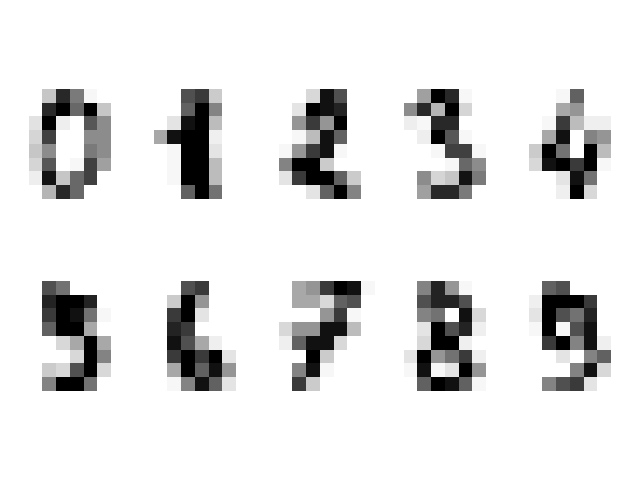

In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as data

# Load dataset and print its description
digits = data.load_digits()
print(digits.DESCR)

# Get dimensions 
nP = digits.data.shape[0]
nF = digits.data.shape[1]

fig = plt.figure()

# Print sample digits
for i in range(10): 
    plt.subplot(2, 5, i + 1)
    idx = list(digits.target).index(i)
    plt.imshow(digits.images[idx], cmap='Greys')
    plt.axis('off')

fig.tight_layout()
plt.show()

In the first activities, you will prepare the dataset, before running any learning algorithms.

---

#### Activity 1.        

From the MNIST dataset, construct the training and test sets. The input data can be accessed as the attribute `data` in the dataset `digits`; the corresponding output data can be accessed as the attribute `target` in `digits`. To build the train and test sets, you can use the function `train_test_split` from the module `model_selection` of `scikit-learn`. Make sure that the test set corresponds to $1/7$th of the total number of samples. 

**Note:** Don't forget to import the necessary modules from `scikit-learn`. Also, for reproducibility, initialize the seed of the `train_test_split` function to a fixed number (e.g., 42).

---

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

X = digits['data']
y = digits['target']

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=(6/7), random_state=42, stratify=y)

### 2. Principal component analysis (PCA)

Right now, each point in the dataset is represented by the pixel information, which roughly corresponds to $64$ features. In this activity, you will determine a small number of alternative features that manage to capture most of the relevant information contained in each picture but which provide a much more compact representation thereto. Such features correspond to the _principal components_ that you will compute next. PCA can be performed through the function `PCA`, in the `decomposition` module of `scikit-learn`. 

---

#### Activity 2.        

* Run PCA on the training set. To do this, you should first fit the PCA model to the train data and then use the resulting model to transform the data. For details, check the documentation for the function `PCA`.

* To grasp how much of the information in the data is contained in the different components, plot the _cumulative explained variance_ (in percentage) as a function of the number of components. The explained variance can be accessed via the attribute `explained_variance_` of your model.

**Note:** In general, before running PCA on some training set, you should _standardize_ the data to make sure that all inputs are centered and lie in the same range. To do this, you can use the function `StandardScaler` of the module `preprocessing` of `scikit-learn`.

---

<IPython.core.display.Javascript object>


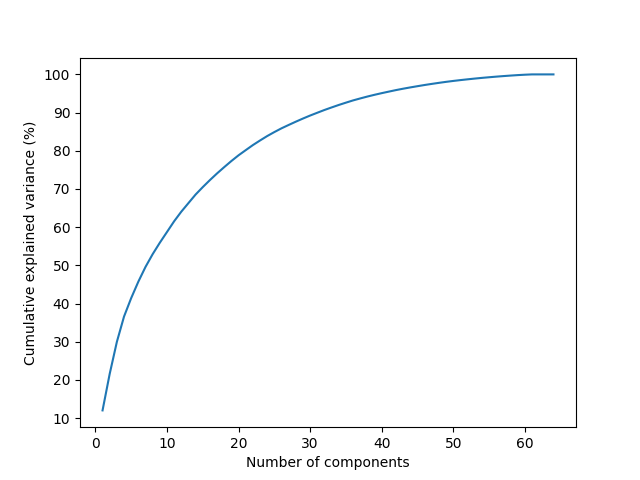

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# standardize data
scaler = StandardScaler()
trnX = scaler.fit_transform(trnX) 
tstX = scaler.transform(tstX)

nr_components = trnX.shape[1]

cum_expl_var_lst = []
nr_components_lst = [i+1 for i in range(nr_components)]


for i in range(nr_components):
    pca = PCA(n_components=i+1)
    pca.fit(trnX)
    cum_expl_var_lst += [pca.explained_variance_ratio_.sum()*100]

# plot the cumulative explained variance as a function of the number of components
plt.figure()
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance (%)')
plt.yticks(np.arange(0, 101, 10))
plt.plot(nr_components_lst, cum_expl_var_lst)
plt.show()

Note how a small number of components explain around 90\% of the variance in the data. As such, it seems reasonable that we may rely only on those components as features to represent our data.

### 3. Impact of number of features on a Logistic Regression classifier

To clearly understand the implications of the adopted representation, you will now run an extensive test to investigate how the number of components may impact the performance of the classifier. 

---

#### Activity 3.        

Take the data in your training set and further split it in two sets, $D_T$ and $D_V$, where $D_T$ corresponds to $85\%$ of the training data and $D_V$ to the remaining $15\%$. You will use $D_T$ for training, and $D_V$ for validation. 

For $k\in\{5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64\}$,

* Run PCA with $k$ components on the data in $D_T$
* Transform the data in $D_T$ using the computed PCA
* Train a logistic regression classifier on the transformed data. Use $C=100$, the `'newton-cg'` solver, and set the multi_class option to `'auto'`
* Compute the error in $D_T$ and in $D_V$

Repeat the _whole process_ (including the split of $D_T$ and $D_V$) 40 times.

**Note 1:** Don't forget that, in order to run PCA, you should standardize the data once again; you should not use the standardized data from Activity 2, since it has seen the whole data in $D_T$ and $D_V$. 

**Note 2:** Also, don't forget that, in order to run your classifier with the data in $D_V$, you must transform it with the PCA fit to $D_T$.

**Note 3:** The whole process may take a while, so don't despair. The logistic regression classifier can be accessed by importing `LogisticRegression` from `sklearn.linear_model`. To compute the error of a classifier, you can use the `accuracy_score` function from `sklearn.metrics`.

---

In [ ]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

k_lst = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
clf = LogisticRegression(C=100, solver='newton-cg', multi_class='auto')

def analysis(clf, X, y):

    trn_errors = {}
    val_errors = {}

    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=(6/7), random_state=42, stratify=y)


    for i in range(40):
        
        trnX1 = trnX.copy()
        trnY1 = trnY.copy()

        # split training set to get a validation set
        trnX1, valX, trnY1, valY = train_test_split(trnX1, trnY1, train_size=0.85, stratify=trnY)

        # scale training and testing set
        scaler = StandardScaler()
        trnX1 = scaler.fit_transform(trnX1) 
        valX = scaler.transform(valX)


        for k in k_lst:
            valX1 = valX.copy()
            valY1 = valY.copy()
            trnX2 = trnX1.copy()
            trnY2 = trnY1.copy()

            pca = PCA(n_components=k)

            # transform training set and testing set using PCA with k components
            trnX2 = pca.fit_transform(trnX2)
            valX1 = pca.transform(valX1)

            # train the classifier on training set
            clf.fit(trnX2, trnY2)

            # predict class labels in training and validation set
            prd_trn_Y = clf.predict(trnX2)
            prd_val_Y = clf.predict(valX1)

            # compute error in training set and validation set
            trn_err = (1 - metrics.accuracy_score(trnY2, prd_trn_Y)) * 100
            val_err = (1 - metrics.accuracy_score(valY1, prd_val_Y)) * 100

            if i == 0: 
                trn_errors[k] = [trn_err]
                val_errors[k] = [val_err]
            else:
                trn_errors[k] += [trn_err]
                val_errors[k] += [val_err]

            
    return trn_errors, val_errors

        
lr_trn_errors, lr_val_errors = analysis(clf, X, y)

---

#### Activity 4.

Plot the average training and validation error from Activity 3 as a function of $k$. Explain the differences observed between the two curves.

---

<IPython.core.display.Javascript object>


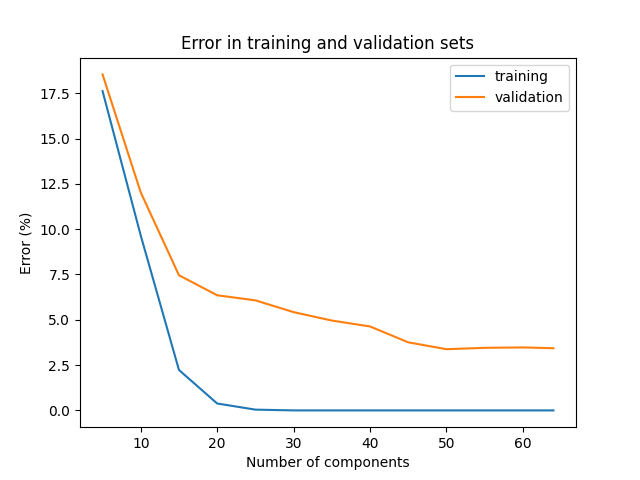

In [15]:
def plot_errors(trn_errors, val_errors):
    avg_trn = []
    avg_val = []

    for k in trn_errors:
        avg = sum(trn_errors[k]) / len(trn_errors[k])
        avg_trn += [avg]
        avg = sum(val_errors[k]) / len(val_errors[k])
        avg_val += [avg]


    # plot the error in trn set and val set according to the number of components
    plt.figure()
    plt.title('Error in training and validation sets')
    plt.xlabel('Number of components')
    plt.ylabel('Error (%)')
    plt.plot(k_lst, avg_trn, label='training')
    plt.plot(k_lst, avg_val, label='validation')
    plt.legend(loc="upper right")
    plt.show()


plot_errors(lr_trn_errors, lr_val_errors)

<span style="color:blue">The classifier fits the model using the training data and so it makes sense that the error is smaller when predicting the training labels. Unless the values in validation set were very similar with the training set, due to a redundant dataset, it would be expected to have a greater error in the validation set.</span>

### 4. Comparison of different classifiers

In Activity 4 you investigated the impact of the number of features on the performance of the Logistic Regression algorithm. You will now compare the performance of the best logistic regression algorithm with another algorithm from the literature.

---

#### Activity 5.        

* Repeat Activity 3 but now using a 5-Nearest Neighbors classifier instead of a Logistic Regression. 
* Plot the average training and validation error as a function of 𝑘.

**Note:** Again, the whole process may take a while, so don't despair. The kNN classifier can be accessed by importing `KNeighborsClassifier` from `sklearn.neighbors`.

---

<IPython.core.display.Javascript object>


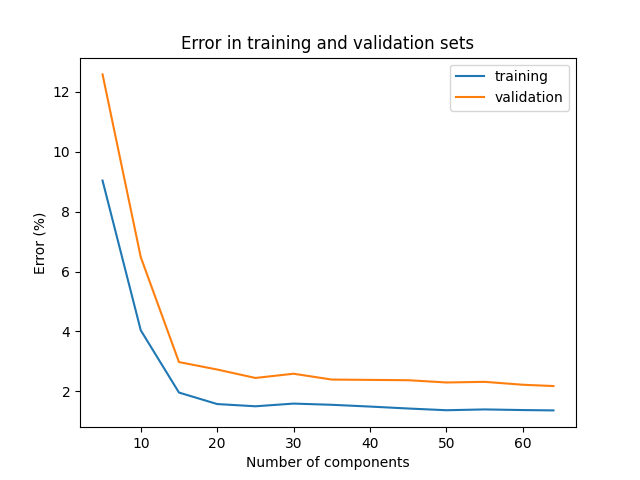

In [18]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

knn_trn_errors, knn_val_errors = analysis(clf, X, y)
plot_errors(knn_trn_errors, knn_val_errors)

---

#### Activity 6.        

Taking into consideration the results from Activities 3 and 5, select the classifier and number of features that you believe is best and

* Compute the performance of your selected classifier on the test data. 
* Comment whether the performance on the test data matches what you expected, based on the results from activities 3 and 5.

**Note:** When computing the performance of your selected classifier, you should re-train it using the whole training data.

---

In [17]:
clf = KNeighborsClassifier()

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=(6/7), random_state=42, stratify=y)

# standardize data
scaler = StandardScaler()
trnX = scaler.fit_transform(trnX) 
tstX = scaler.transform(tstX)

pca = PCA(n_components=25)

# transform training set and testing set using PCA with 16 components
trnX = pca.fit_transform(trnX)
tstX = pca.transform(tstX)

# train the classifier on training set
clf.fit(trnX, trnY)

# predict class labels in testing set
prdY = clf.predict(tstX)

# compute accuracy in testing set
error_tst = 100 - metrics.accuracy_score(tstY, prdY) * 100

print(error_tst)

3.112840466926073


<span style="color:blue">We chose the KNN classifier with a PCA of 25 components and we expected the error to be around 2%-3%. The computed error was 3.11%, which is close to our expectations.</span>